## Preparations

First off, the imports: We need the usual external dependencies for calcualtion and plotting:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product               # Cartesian product for iterators
save_name = 'gen5'
import os
os.makedirs(save_name, exist_ok=True)

and our framework to hide the boring stuff:

In [4]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src/irl_maxent')))

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

Let's also use interactive javascript-based plots and pre-define a global style for plotting:

In [5]:
#%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [6]:
def setup_mdp():
    # create our world
    world = W.BirdWorld(width=7, height=8)

    # set up the reward function
    reward = np.zeros(world.n_states)
    # reward[-1] = 1.0
    # reward[8] = 0.65

    # set up terminal states
    terminal = [2]

    return world, reward, terminal

# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp()

In [7]:
from data_loader import get_all_trajectories
# data = load_data('action_space.csv')
trajectories = get_all_trajectories()

In [8]:
# fig = plt.figure()
# ax = fig.add_subplot(121)
# ax.title.set_text('Original Reward')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# p = P.plot_state_values(ax, world, reward, **style)
# fig.colorbar(p, cax=cax)

# ax = fig.add_subplot(122)
# ax.title.set_text('Expert Policy and Trajectories')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# # p = P.plot_stochastic_policy(ax, world, expert_policy, **style)
# fig.colorbar(p, cax=cax)

# # for t in trajectories:
# #     P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

# fig.tight_layout()
# # plt.savefig('expert_trajectories.png')
# plt.show()

With that done, we have all the prequisites we need to run the actual algorithm.

In [9]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [10]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

With that we're ready to look at the algorithm computing the expected state visitation frequency (this is Algorithm 1 in the Maximum Entropy IRL paper by Ziebart et al. [\[Ziebart et al. 2008\]](#References)).
As already mentioned above, this algorithm consists of two parts: A backward pass computing the local action probabilities $\pi(a \mid s, \omega)$ and a forward pass computing the state visitation frequencies $D_{s_i}$ from those.

For the **backward-pass** we recursively back-up from terminal states (initialized with $Z_{s_i} = 1$), computing the state and state-action partition functions $Z_{s_i}$ and $Z_{s_i, a_j}$.
When we have those, we can compute the local action probability using $\pi(a_j \mid s_i, \omega)$.
A technical issue we stumble accross here, is that this process does not converge.
To this end, we choose to run $2 \cdot |S|$ iterations, as this ensures the maximum trajectory length is covered ($|S|$) and we have some slack.
As explained previously, the equations we need for this are

$$
    \pi(a_j \mid s_i, \omega) = \frac{Z_{s_i, a_j}}{Z_{s_j}}
    ,\quad
    Z_{s_i, a_j} = \sum_{k} p(s_k \mid s_i, a_j)\, \exp \left(\omega^\top \phi(s_i)\right)\, Z_{s_k}
    ,\quad
    Z_{s_i} = \sum_{a_j} Z_{s_i, a_j}.
$$

For the **forward-pass** we initialize the state-visitation frequency with the probability of a state being a starting-point (`p_initial` $= p(s_0)$).
To compute the state-visitation-frequency for another state, we just sum up the transition probabilities of (direct) transitions to this other state multiplied by the state-visitation frequency of the origin-state of this transition, resulting in a forward-propagation of state-visitation frequencies.
Also, we only consider transitions originating in non-terminal states.
Expressed as formula, we iteratively compute

$$
    D_{s_k, t + 1}
    = \sum_{s_i \in S_{\text{nt}}} \sum_{a_j \in A} D_{s_i, t} \; \pi(a_j \mid s_i) \; p(s_k \mid s_i, a_j)
$$

and then sum this up over all time-steps $t$ for the final result.
Again, we run $2 \cdot |S|$ iterations, altough this algorithm can also be modified for convergence (see `expected_svf_from_policy(...)` in the accompanying code).

In [11]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
        
        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

Now we can look at the core algorithm:
First, we compute the feature expectation $\mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]$ and starting-state probabilities using the functions defined above.
Those are static, so we only need to compute them once before we start optimizing.
After this, we initialize our parameters $\omega$ and then iteratively perform optimization-steps until convergence is reached.
For each optimization-step, we compute the gradient

$$
    \nabla_\omega \mathcal{L}(\omega)
    = \mathbb{E}_{\pi^E} \left[ \phi(\tau) \right] - \sum_{s_i} D_{s_i} \phi(s_i),
$$

using the function above to get the expected state-visitation frequency $D_{s_i}$ from our current recovered reward $R(s_i) = \omega^\top \phi(s_i)$.

In [12]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    iter = 0                        # iteration counter
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute delta for convergence check
        delta = np.max(np.abs(omega_old - omega))
        print(f'{iter:4d} | {delta:.6f}', end='\r', flush=True)
        iter += 1

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Recovered Reward')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        p = P.plot_state_values(ax, world, reward, **style)
        # P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')
        fig.colorbar(p, cax=cax)

        fig.tight_layout()
        plt.savefig(f'{save_name}/recovered_reward_{iter}.png')
        plt.close()
        # Break nicely:
        if iter > 20:
            break


    # re-compute per-state reward and return
    return features.dot(omega)

We've defined everything we need, so we can now finally run the algorithm.
For that, we first get our feature-mapping: We're using one-hot vectors here, so our features are a set of orthogonal vectors, one per state.
We select an initialization strategy for our parameters:, specifically we just set them all to one, and we choose exponentiated gradient ascent an optimizer [\[Kivinen et. al. 1997\]](#References).
All of those parameters can, of course, be tuned and adapted to the scenario.

In [13]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
# O.linear_decay(lr0=0.06)
optim = O.ExpSga(lr=0.6)

# actually do some inverse reinforcement learning
reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init, eps=1e-4)

Now let's look at our results and compare them to the original reward.
Also show the optimal policies derived from both reward functions.

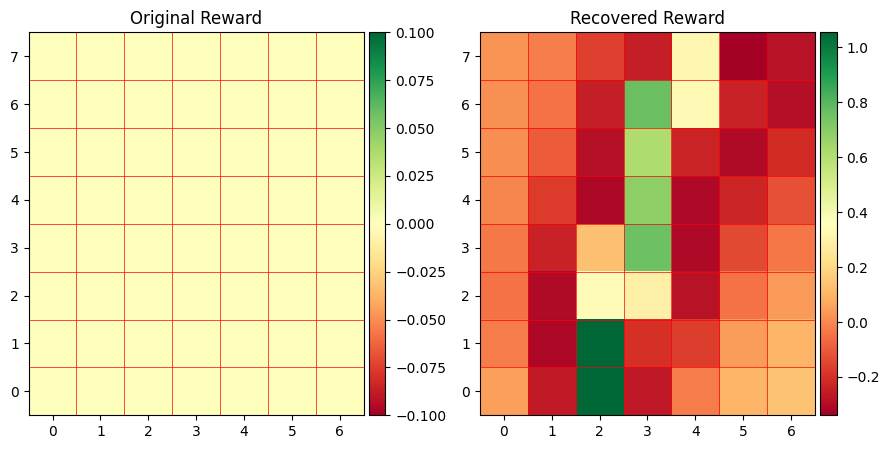

In [14]:
# style['cmap'] = 'coolwarm
# color map with red to green:
style['cmap'] = 'RdYlGn'
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
# P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.8), color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
reward_maxent -= reward_maxent.mean()
p = P.plot_state_values(ax, world, reward_maxent, **style)
# P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.savefig(f'{save_name}/recovered_reward.png')
plt.show()

We can also compare the feature-expectation:

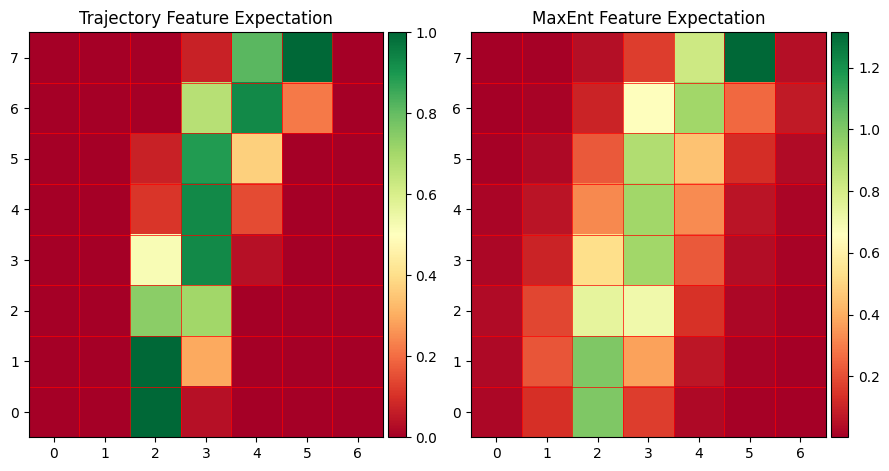

In [15]:
# Note: this code will only work with one feature per state
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_expectation_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, e_features, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, features.T.dot(e_svf), **style)
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()

## References

- \[Abbel & Ng 2004\]: https://doi.org/10.1145/1015330.1015430
- \[Bishop 2006\]: https://www.springer.com/us/book/9780387310732
- \[Jaynes 1957\]: https://doi.org/10.1103/physrev.106.620
- \[Kivinen et. al. 1997\]: https://doi.org/10.1006/inco.1996.2612
- \[Ng et al. 99\]: https://dl.acm.org/citation.cfm?id=645528.657613
- \[Osa et al. 2018\]: https://arxiv.org/abs/1811.06711
- \[Ziebart et al. 2008\]: http://www.cs.cmu.edu/~bziebart/publications/maximum-entropy-inverse-reinforcement-learning.html
- \[Ziebart 2010\]: https://www.cs.cmu.edu/~bziebart/publications/thesis-bziebart.pdf

Note: Most of these resources are freely available.